## XGBooster classification

In [153]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold



In [137]:
df = pd.read_csv("../Data/Combined_Delayed_2Days.csv")
df.set_index("Date",inplace= True)
df.head()


,Tweets_clean_more,polarity,subjectivity,sentiment,Label_delayed_2Days
Date,,,,,
2013-01-10,to super clear i dont wish could i mandat anyt...,0.216667,0.525000,positive,Decrease
2019-01-10,ye get regulatori pushback may avail region go...,0.123333,0.490556,positive,Increase
2020-01-10,dome barrel weld made bar pretti good bar need...,0.411111,0.570988,positive,Decrease
2012-01-11,the exec conf room tesla use call denali i dec...,0.600000,1.000000,positive,Decrease
2016-01-11,sad hear david bowi die he amaz,-0.500000,1.000000,negative,Increase


In [138]:
x = df['Tweets_clean_more']
y = df["Label_delayed_2Days"]
le = LabelEncoder()
le.fit(y)
#y = y.replace({'Increase':1,'Decrease':-1,'No Change':0})
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size = 0.8, random_state=123)


In [139]:
y_train = le.transform(y_train)
y_test = le.transform(y_test)
print(y_train)

[0 1 0 ... 1 0 1]


In [140]:
vectorizer = TfidfVectorizer()
vectorizer.fit(x_train)
x_train = vectorizer.transform(x_train)
x_test = vectorizer.transform(x_test)
print(x_train.shape,x_test.shape)

(1136, 6562) (284, 6562)


Best: -0.858902 using {'learning_rate': 0.1}
-1.095603 (0.000159) with: {'learning_rate': 0.0001}
-1.070417 (0.001508) with: {'learning_rate': 0.001}
-0.925437 (0.009776) with: {'learning_rate': 0.01}
-0.858902 (0.030075) with: {'learning_rate': 0.1}
-0.915198 (0.038395) with: {'learning_rate': 0.2}
-0.974245 (0.050912) with: {'learning_rate': 0.3}


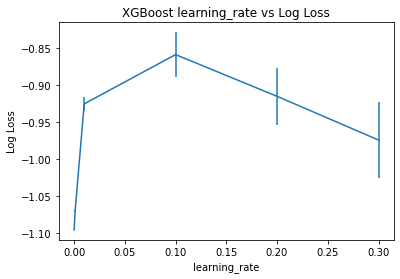

In [157]:
model = XGBClassifier()
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learning_rate=learning_rate)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


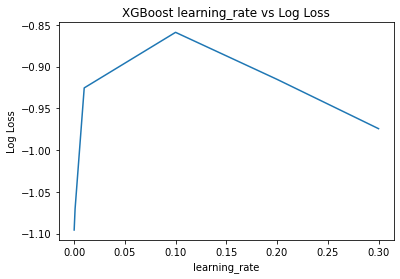

In [159]:
plt.plot(learning_rate, means)
plt.title("XGBoost learning_rate vs Log Loss")
plt.xlabel('learning_rate')
plt.ylabel('Log Loss')
plt.show()

Model report:
classification report:
               precision    recall  f1-score   support

           0       0.51      0.46      0.48       140
           1       0.52      0.60      0.56       139
           2       0.00      0.00      0.00         5

    accuracy                           0.52       284
   macro avg       0.34      0.35      0.35       284
weighted avg       0.51      0.52      0.51       284

Accuracy score:  0.5176056338028169
F1 Score: 0.5176056338028169


/Users/taoyu/opt/anaconda3/envs/anly-580/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/taoyu/opt/anaconda3/envs/anly-580/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/taoyu/opt/anaconda3/envs/anly-580/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

<AxesSubplot:>

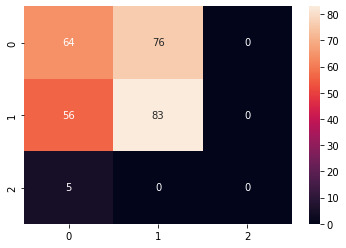

In [160]:
clf = XGBClassifier(random_state=42, seed=2, learning_rate=0.1) # label encoder as input
clf.fit(x_train,y_train)
ypred_train = clf.predict(x_train)
ypred_test = clf.predict(x_test)
#print(ypred_train) #010101
#print(ypred_test) # 010101

cm = confusion_matrix(y_test,ypred_test)
acc = accuracy_score(y_test,ypred_test)
print("Model report:")
print("classification report:\n",classification_report(y_test,ypred_test))
print("Accuracy score: ",acc)
print("F1 Score:",f1_score(y_test,ypred_test,average="micro"))
#print("ROC AUC Score:",roc_auc_score(y_test, ypred_test, average='micro'))
sns.heatmap(cm,annot=True)